**Лабораторна робота №2. Методи класифікації**

Приблизний строк виконання - 12 годин

**Рекомендована дата здачі: 28 листопада 2021 року**

Виконала студентка групи [КМ-11мн] [Коваленко Олександра Петрівна]

Студент здав роботу: (заповнюється викладачем відповідно до дати повідомлення з роботою у Slack)

Студент захистив роботу на оцінку: (заповнюється викладачем)

**Зауваження до виконання роботи: алгоритми побудови (створення) дерева рішень, k найближчих сусідів, Наївного Байєсівського класифікатора і механізм К-кратної крос-валідації потрібно запрограмувати власноруч.**

###lib

In [ ]:
pip install scipy

In [ ]:
pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
import scikitplot as skplt
from scipy.stats import mode

**Лабораторна робота №2. Методи класифікації**

Приблизний строк виконання - 12 годин

**Рекомендована дата здачі: 28 листопада 2021 року**

Виконав студент групи [№ групи] [ПІБ студента/студентки]

Студент здав роботу: (заповнюється викладачем відповідно до дати повідомлення з роботою у Slack)

Студент захистив роботу на оцінку: (заповнюється викладачем)

**Зауваження до виконання роботи: алгоритми побудови (створення) дерева рішень, k найближчих сусідів, Наївного Байєсівського класифікатора і механізм К-кратної крос-валідації потрібно запрограмувати власноруч.**

###**Частина 1. Дерева рішень**
1. Обрати відповідний файл з даними.
2. Збудувати дерево прийняття рішень для визначення значення цільової характеристики (останній стовпчик) на основі вхідних аргументів (інші стовпчики). Записи у файлі з даними потрібно розділити на навчальну та відкладену вибірки.
3. Параметри дерева та алгоритм його побудови обрати самостійно.
Дерево не повинно бути занадто гіллястим, за потреби використовуйте процедуру обрізання. Використовувати бібліотечні функції забороняється.
4. Оцінити якість збудованого дерева за допомогою методу відкладеної вибірки. Надати графічне порівняння результатів, отриманих за допомогою застосування збудованого дерева прийняття рішень до відкладеної вибірки, із фактичними значеннями цільової характеристики.
5. Застосувати для визначення цільової характеристики на даних відкладеної вибірки метод k найближчих сусідів. Визначити кількість сусідів, при якій метод дає найкращу точність.
6. Порівняти результати з п.п. 4 та 5.


In [ ]:
#pd.options.display.max_rows = 300

In [ ]:
file_url = "https://raw.githubusercontent.com/IvanSergeyevichZhuk/ML_KPI/main/Data/Lab2/Part1/MN/MN09-Kovalenko.csv"
data = pd.read_csv(file_url, header=None)
data = data.set_axis([0, 1, 2, 3, 4, 5, 6, 7, 8] , axis=1)
data=pd.get_dummies(data=data, columns=[0, 1, 2, 3, 4, 5, 6, 7])
data

,8,0_usual,1_critical,1_improper,2_complete,2_foster,3_1,3_2,3_3,3_more,4_convenient,4_critical,4_less_conv,5_convenient,5_inconv,6_nonprob,6_problematic,6_slightly_prob,7_not_recom,7_priority,7_recommended
0,priority,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1
1,priority,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0
2,not_recom,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0
3,priority,1,0,1,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1
4,priority,1,0,1,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,spec_prior,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0
296,not_recom,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0
297,spec_prior,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1
298,spec_prior,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0


In [ ]:
data[8].unique()

array(['priority', 'not_recom', 'very_recom', 'spec_prior'], dtype=object)

In [ ]:
TRAIN = data.iloc[:200]
TEST = data.iloc[-50:].reset_index(drop = True)

X_train = TRAIN.iloc[:,1:]
X_test = TEST.iloc[:,1:]

Y_train = TRAIN.iloc[:,:1]
Y_test = TEST.iloc[:,:1]

### Desicion Tree

In [ ]:
class DTC:

    def __init__(self, max_depth = 5, depth = 1):
        self.max_depth = max_depth
        self.depth = depth
        self.left = None
        self.right = None
    
    def fit(self, x_train, x_test):
        self.x_train = x_train
        self.x_test = x_test
        self.columns = self.x_train.columns.tolist()
        self.columns.remove(x_test)
        if self.depth <= self.max_depth:
            self.__validate_x_train()
            self.impurity_score = self.gini(self.x_train[self.x_test])
            self.criteria, self.split_feature, self.information_gain = self.splt()
            if self.criteria is not None and self.information_gain > 0: self.branches()
        else: 
            print("Stopping splitting as Max depth reached")
    
    def branches(self):
        self.left = DTC(max_depth = self.max_depth, depth = self.depth + 1)
        self.right = DTC(max_depth = self.max_depth, depth = self.depth + 1)
        left_rows = self.x_train[self.x_train[self.split_feature] <= self.criteria] 
        right_rows = self.x_train[self.x_train[self.split_feature] > self.criteria] 
        self.left.fit(x_train = left_rows, x_test = self.x_test)
        self.right.fit(x_train = right_rows, x_test = self.x_test)
    
    def gini(self, x_train):
        if x_train is None or x_train.empty:
          return 0
        gini_impurity = 1.
        classes = np.unique(x_train)
        n_vals = len(x_train)
        for cl in classes:
            gini_impurity -= np.square(np.sum(x_train==cl)/n_vals) 
        return gini_impurity
    
    def splt(self):
        best_split = {}
        for col in self.columns:
            information_gain, split = self.splt_for_column(col)
            if split is None: continue
            if not best_split or best_split["information_gain"] < information_gain:
                best_split = {"split": split, "col": col, "information_gain": information_gain}
        return best_split.get("split"), best_split.get("col"), best_split.get("information_gain")

    def splt_for_column(self, col):
        x = self.x_train[col]
        unique_values = x.unique()
        if len(unique_values) == 1:
           return None, None
        information_gain = None
        split = None
        for val in unique_values:
            left = x <= val
            right = x > val
            left_x_train = self.x_train[left]
            right_x_train = self.x_train[right]
            left_impurity = self.gini(left_x_train[self.x_test])
            right_impurity = self.gini(right_x_train[self.x_test])
            score = self.impurity_score - ((len(left_x_train)/len(self.x_train)) * left_impurity + (len(right_x_train)/len(self.x_train)) * right_impurity)
            if information_gain is None or score > information_gain: 
                information_gain = score 
                split = val
        return information_gain, split

    def predict(self, x_train):
        return np.array([self.__flow_x_train_thru_tree(row) for _, row in x_train.iterrows()])

    def __validate_x_train(self):
        non_numeric_columns = self.x_train[self.columns].select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
        if(len(set(self.columns).intersection(set(non_numeric_columns))) != 0):
            raise RuntimeError("Not all columns are numeric")

    def __flow_x_train_thru_tree(self, row):
        if self.is_leaf_node:
          return self.probability
        tree = self.left if row[self.split_feature] <= self.criteria else self.right
        return tree.__flow_x_train_thru_tree(row)
        
    @property
    def is_leaf_node(self):
      return self.left is None
    @property
    def probability(self): 
        return mode(self.x_train[self.x_test])[0][0]

In [ ]:
clf = DTC(max_depth= 3)
fit = clf.fit(TRAIN, 8)
predict = clf.predict(X_test)
predict

Stopping splitting as Max depth reached
Stopping splitting as Max depth reached


array(['priority', 'not_recom', 'priority', 'priority', 'not_recom',
       'priority', 'priority', 'not_recom', 'priority', 'priority',
       'not_recom', 'priority', 'priority', 'not_recom', 'priority',
       'priority', 'not_recom', 'priority', 'priority', 'not_recom',
       'priority', 'priority', 'not_recom', 'priority', 'priority',
       'not_recom', 'priority', 'priority', 'not_recom', 'priority',
       'priority', 'not_recom', 'priority', 'priority', 'not_recom',
       'priority', 'priority', 'not_recom', 'priority', 'priority',
       'not_recom', 'priority', 'priority', 'not_recom', 'priority',
       'priority', 'not_recom', 'priority', 'priority', 'not_recom'],
      dtype='<U9')

In [ ]:
df = pd.DataFrame()
df["actual"] = Y_test[8].to_numpy()
df["predict_DTC"] = predict
df

,actual,predict_DTC
0,priority,priority
1,not_recom,not_recom
2,priority,priority
3,priority,priority
4,not_recom,not_recom
5,priority,priority
6,priority,priority
7,not_recom,not_recom
8,priority,priority
9,priority,priority


###Оцінка

In [ ]:
deferred_sampling = (df["actual"] == df["predict_DTC"])
np.count_nonzero(deferred_sampling == True)/len(df["predict_DTC"])

0.84

In [ ]:
def metric(actual, predict):
  T_priority = sum((actual == 'priority') & (predict == 'priority'))
  F_priority_not_recom = sum((actual == 'priority') & (predict == 'not_recom'))
  F_priority_very_recom = sum((actual == 'priority') & (predict == 'very_recom'))
  F_priority_spec_prior = sum((actual == 'priority') & (predict == 'spec_prior'))

  T_not_recom = sum((actual == 'not_recom') & (predict == 'not_recom'))
  F_not_recom_priority = sum((actual == 'not_recom') & (predict == 'priority'))
  F_not_recom_very_recom = sum((actual == 'not_recom') & (predict == 'very_recom'))
  F_not_recom_spec_prior = sum((actual == 'not_recom') & (predict == 'spec_prior'))

  T_very_recom = sum((actual == 'very_recom') & (predict == 'very_recom'))
  F_very_recom_priority = sum((actual == 'very_recom') & (predict == 'priority'))
  F_very_recom_not_recom = sum((actual == 'very_recom') & (predict == 'not_recom'))
  F_very_recom_spec_prior = sum((actual == 'very_recom') & (predict == 'spec_prior'))

  T_spec_prior = sum((actual == 'spec_prior') & (predict == 'spec_prior'))
  F_spec_prior_priority = sum((actual == 'spec_prior') & (predict == 'priority'))
  F_spec_prior_not_recom = sum((actual == 'spec_prior') & (predict == 'not_recom'))
  F_spec_prior_very_recom = sum((actual == 'spec_prior') & (predict == 'very_recom'))

  print("confusion_matrix:\n", np.array([[T_priority, F_priority_not_recom, F_priority_very_recom, F_priority_spec_prior],
                                         [F_not_recom_priority, T_not_recom, F_not_recom_very_recom, F_not_recom_spec_prior],
                                         [F_very_recom_priority, F_very_recom_not_recom, T_very_recom, F_very_recom_spec_prior],
                                         [F_spec_prior_priority, F_spec_prior_not_recom, F_spec_prior_very_recom, T_spec_prior]]))

In [ ]:
metric(df["actual"], df['predict_DTC'])

confusion_matrix:
 [[25  0  0  0]
 [ 0 17  0  0]
 [ 0  0  0  0]
 [ 8  0  0  0]]


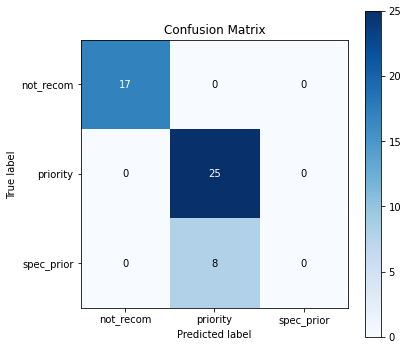

In [ ]:
skplt.metrics.plot_confusion_matrix(df["actual"], df['predict_DTC'], figsize=(6,6))

###KNN

In [ ]:
def KNN(x_train, y_train , x_test, k):

    pred = []
    for val in x_test: 
        score_length = []
        for j in range(len(x_train)): 
            score_length.append(np.sqrt(np.sum(((np.array(x_train[j,:])) - val)**2))) 
        score_lengtht = np.array(score_length) 
        pred.append(y_train[np.argsort(score_length)[:k]])
        x = []
        for i in range(len(Y_test)):
          y = pred 
          x = np.array(y)
          predict_KNN = []
        for i in x:
          predict_KNN.append(i[0][0])

    return predict_KNN

In [ ]:
X_train1 = X_train.to_numpy().astype('int64')
X_test1 = X_test.to_numpy().astype('int64')
Y_train1 = Y_train.to_numpy()

In [ ]:
pred = KNN(X_train1, Y_train1, X_test1, 1)

In [ ]:
df["predict_KNN"] = pred
df

,actual,predict_DTC,predict_KNN
0,priority,priority,priority
1,not_recom,not_recom,not_recom
2,priority,priority,priority
3,priority,priority,priority
4,not_recom,not_recom,priority
5,priority,priority,priority
6,priority,priority,priority
7,not_recom,not_recom,not_recom
8,priority,priority,priority
9,priority,priority,priority


In [ ]:
deferred_sampling = (df["actual"] == df["predict_KNN"])
np.count_nonzero(deferred_sampling == True)/len(df["predict_KNN"])

0.82

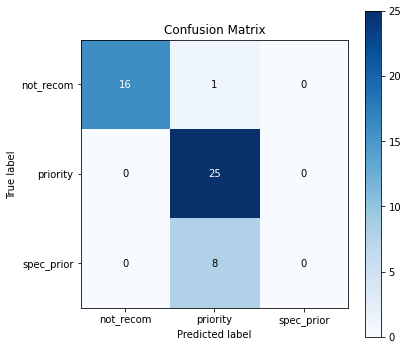

In [ ]:
skplt.metrics.plot_confusion_matrix(df["actual"], df["predict_KNN"], figsize=(6,6))

###**Частина 2. Метод k найближчих сусідів**

1. Обрати відповідний файл з даними.
2. Використайте для класифікації перші 100 записів у файлі з даними і прокласифікуйте останні 25 записів, використовуючи метод k найближчих сусідів, використовуючи 3 різні значення k і Евклідову метрику для визначення відстані.
3. Для зробленої класифікації:

1) Обчислити метрики accuracy, точності (precision), повноти (recall), $F_1$, MCC (Коефіцієнт кореляції Метьюса), Каппа Коена.

2) Обчислити матрицю помилок (confusion matrix).

3) Візуалізувати результати класифікації, вивівши результати класифікації як точки в системі координат (x1, x2). В якості пар змінних x1, x2 використати будь-які три пари стовпчиків. Зафарбувати точки у відповідності до їх значень у останньому стовпчику.

4. Провести таку саму класифікацію, використовуючи будь-які дві інші метрики відстані. Проаналізувати результати двох окремих класифікацій за п.3.

5. Виконати пункти 2-4, використовуючи перші 200 записів з файлу для навчання моделей і 50 останніх записів з файлу для тестування.

6. Виконати пункти 2-4, використавши алгоритм k-кратної крос валідації (K-Fold cross validation) до наданого датасету.

7. Проаналізуйте отримані результати.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [ ]:
file_url2 = "https://raw.githubusercontent.com/Alexandra-Kovalenko1/data/main/MN09-Kovalenko_lab2.csv"
df2 = pd.read_csv(file_url2, sep=';', decimal=',')
df2=df2.set_axis([0, 1, 2, 3, 4, 5, 6, 7] , axis=1)
df2

,0,1,2,3,4,5,6,7
0,0.395,0.270,0.100,0.2985,0.1445,0.0610,0.0820,5
1,0.400,0.290,0.100,0.2675,0.1205,0.0605,0.0765,5
2,0.405,0.285,0.090,0.2645,0.1265,0.0505,0.0750,6
3,0.410,0.335,0.110,0.3300,0.1570,0.0705,0.1700,7
4,0.420,0.305,0.090,0.3280,0.1680,0.0615,0.0820,6
...,...,...,...,...,...,...,...,...
294,0.365,0.270,0.085,0.2225,0.0935,0.0525,0.0660,7
295,0.370,0.270,0.095,0.2175,0.0970,0.0460,0.0650,6
296,0.375,0.280,0.080,0.2165,0.0935,0.0925,0.0700,7
297,0.380,0.285,0.095,0.2430,0.0895,0.0665,0.0750,7


In [ ]:
df2[7].unique()

array([ 5,  6,  7,  8,  9, 11, 13, 10, 12, 15, 14,  3,  4])

In [ ]:
train = df2.iloc[:100]
test = df2.iloc[-25:]

x_train = train.iloc[:,:-1].reset_index(drop=True).to_numpy()
x_test = test.iloc[:,:-1].reset_index(drop=True).to_numpy()

y_train = train.iloc[:,-1:].reset_index(drop=True).to_numpy()
y_test = test.iloc[:,-1:].reset_index(drop=True).to_numpy()

In [ ]:
TRAIN = df2.iloc[:200]
TEST = df2.iloc[-50:]

X_train = TRAIN.iloc[:,:-1].reset_index(drop=True).to_numpy()
X_test = TEST.iloc[:,:-1].reset_index(drop=True).to_numpy()

Y_train = TRAIN.iloc[:,-1:].reset_index(drop=True).to_numpy()
Y_test = TEST.iloc[:,-1:].reset_index(drop=True).to_numpy()

###Евклід 100/25

In [ ]:
def KNN_eucledian(x_train, y_train , x_test, k):

    pred = []
    for val in x_test: 
        score_length = []
        for j in range(len(x_train)): 
            score_length.append(np.sqrt(np.sum(((np.array(x_train[j,:])) - val)**2))) 
        score_lengtht = np.array(score_length) 
        pred.append(y_train[np.argsort(score_length)[:k]])
        x = []
        for i in range(len(Y_test)):
          y = pred 
          x = np.array(y)
          predict = []
        for i in x:
          predict.append(i[0][0])

    return predict

In [ ]:
predict_eucledian3 = KNN_eucledian(x_train, y_train, x_test, 3)
predict_eucledian6 = KNN_eucledian(x_train, y_train, x_test, 6)
predict_eucledian9 = KNN_eucledian(x_train, y_train, x_test, 9)

In [ ]:
def metric(Y_test, y_pred):
  print('accuracy', accuracy_score(Y_test, y_pred))
  print('precision', precision_score( Y_test, y_pred, average = 'macro'))
  print('recall', recall_score(Y_test, y_pred, average = 'macro'))
  print('F1', f1_score(Y_test, y_pred, average='macro'))
  print('MCC', matthews_corrcoef(Y_test, y_pred))
  print('Kappa Cohen', cohen_kappa_score(Y_test, y_pred))
  print('Confusion Matrix\n', confusion_matrix(Y_test, y_pred))

In [ ]:
metric(y_test, predict_eucledian3)

accuracy 0.28
precision 0.08806818181818182
recall 0.22916666666666669
F1 0.12352941176470589
MCC 0.1508320133961877
Kappa Cohen 0.1329479768786126
Confusion Matrix
 [[0 4 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0]
 [4 2 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 1 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



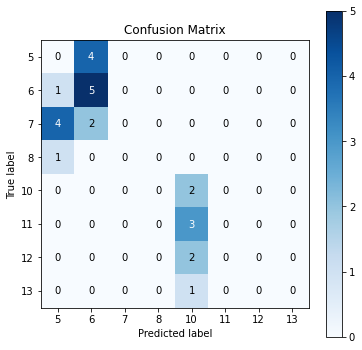

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predict_eucledian3, figsize=(6,6))

In [ ]:
metric(y_test, predict_eucledian6)

accuracy 0.28
precision 0.08806818181818182
recall 0.22916666666666669
F1 0.12352941176470589
MCC 0.1508320133961877
Kappa Cohen 0.1329479768786126
Confusion Matrix
 [[0 4 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0]
 [4 2 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 1 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



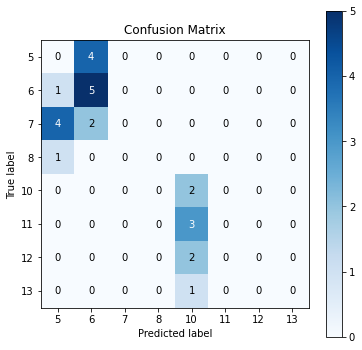

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predict_eucledian6, figsize=(6,6))

In [ ]:
metric(y_test, predict_eucledian9)

accuracy 0.28
precision 0.08806818181818182
recall 0.22916666666666669
F1 0.12352941176470589
MCC 0.1508320133961877
Kappa Cohen 0.1329479768786126
Confusion Matrix
 [[0 4 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0]
 [4 2 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 0 0 1 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



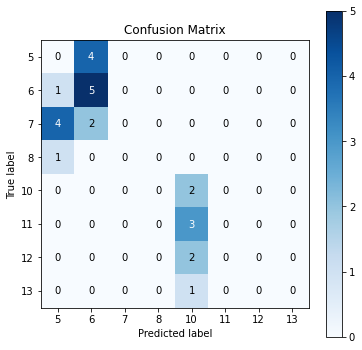

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predict_eucledian9, figsize=(6,6))

###Чебишева  100/25

In [ ]:
def KNN_chebushev(x_train, y_train , x_test, k):

    pred = []
    for val in x_test: 
        score_length = []
        for j in range(len(x_train)): 
            score_length.append(abs(max((np.array(x_train[j,:])) - val))) 
        score_lengtht = np.array(score_length) 
        pred.append(y_train[np.argsort(score_length)[:k]])
        x = []
        for i in range(len(Y_test)):
          y = pred 
          x = np.array(y)
          predict = []
        for i in x:
          predict.append(i[0][0])

    return predict

In [ ]:
predict_chebushev3 = KNN_chebushev(x_train, y_train, x_test, 3)
predict_chebushev6 = KNN_chebushev(x_train, y_train, x_test, 6)
predict_chebushev9 = KNN_chebushev(x_train, y_train, x_test, 9)

In [ ]:
metric(y_test, predict_chebushev3)

accuracy 0.28
precision 0.06018518518518518
recall 0.16666666666666666
F1 0.08838383838383838
MCC 0.1528406048613942
Kappa Cohen 0.12280701754385981
Confusion Matrix
 [[0 4 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 2 0 0 0]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



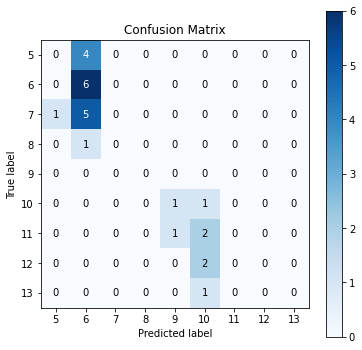

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predict_chebushev3, figsize=(6,6))

In [ ]:
metric(y_test, predict_chebushev6)

accuracy 0.28
precision 0.06018518518518518
recall 0.16666666666666666
F1 0.08838383838383838
MCC 0.1528406048613942
Kappa Cohen 0.12280701754385981
Confusion Matrix
 [[0 4 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 2 0 0 0]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



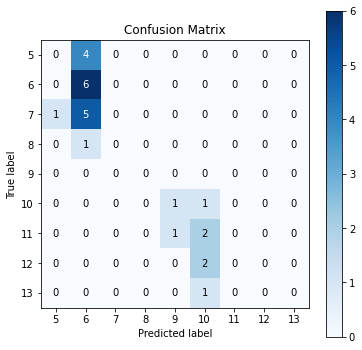

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predict_chebushev6, figsize=(6,6))

In [ ]:
metric(y_test, predict_chebushev9)

accuracy 0.28
precision 0.06018518518518518
recall 0.16666666666666666
F1 0.08838383838383838
MCC 0.1528406048613942
Kappa Cohen 0.12280701754385981
Confusion Matrix
 [[0 4 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 2 0 0 0]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



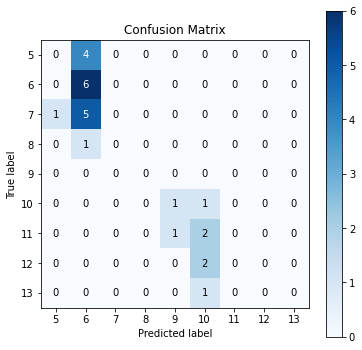

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predict_chebushev9, figsize=(6,6))

###L1  100/25

In [ ]:
def KNN_L1(x_train, y_train , x_test, k):

    pred = []
    for val in x_test: 
        score_length = []
        for j in range(len(x_train)): 
            score_length.append(abs((np.array(x_train[j,:])) - val)) 
        score_lengtht = np.array(score_length) 
        pred.append(y_train[np.argsort(score_length)[:k]])
        x = []
        for i in range(len(Y_test)):
          y = pred 
          x = np.array(y)
          predict = []
        for i in x:
          predict.append(i[0][0])

    return predict

In [ ]:
predict_L13 = KNN_L1(x_train, y_train, x_test, 3)
predict_L16 = KNN_L1(x_train, y_train, x_test, 6)
predict_L19 = KNN_L1(x_train, y_train, x_test, 9)

In [ ]:
metric(y_test, predict_L13)

accuracy 0.24
precision 0.06346153846153846
recall 0.14583333333333331
F1 0.08834586466165414
MCC 0.046837508406748045
Kappa Cohen 0.04040404040404022
Confusion Matrix
 [[2 0 2 0 0 0 0 0]
 [2 4 0 0 0 0 0 0]
 [5 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



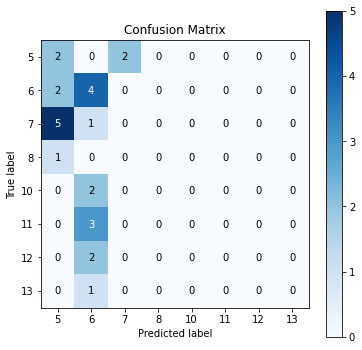

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predict_L13, figsize=(6,6))

In [ ]:
metric(y_test, predict_L16)

accuracy 0.24
precision 0.06346153846153846
recall 0.14583333333333331
F1 0.08834586466165414
MCC 0.046837508406748045
Kappa Cohen 0.04040404040404022
Confusion Matrix
 [[2 0 2 0 0 0 0 0]
 [2 4 0 0 0 0 0 0]
 [5 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



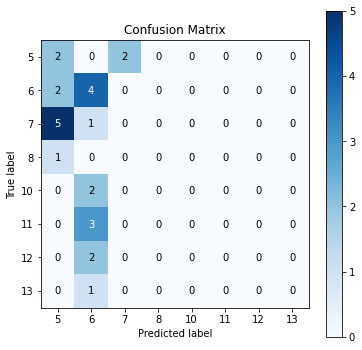

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predict_L16, figsize=(6,6))

In [ ]:
metric(y_test, predict_L19)

accuracy 0.24
precision 0.06346153846153846
recall 0.14583333333333331
F1 0.08834586466165414
MCC 0.046837508406748045
Kappa Cohen 0.04040404040404022
Confusion Matrix
 [[2 0 2 0 0 0 0 0]
 [2 4 0 0 0 0 0 0]
 [5 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



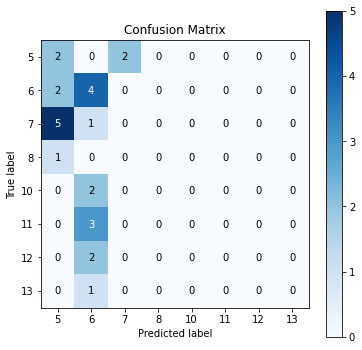

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predict_L19, figsize=(6,6))

### Евклід 200/50

In [ ]:
predict_eucledian3 = KNN_eucledian(X_train, Y_train, X_test, 3)
predict_eucledian6 = KNN_eucledian(X_train, Y_train, X_test, 6)
predict_eucledian9 = KNN_eucledian(X_train, Y_train, X_test, 9)

In [ ]:
metric(Y_test, predict_eucledian3)

accuracy 0.3
precision 0.12261904761904763
recall 0.1628787878787879
F1 0.13272946859903384
MCC 0.19227926343849758
Kappa Cohen 0.18338777414838991
Confusion Matrix
 [[0 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 2 1 1 0]
 [0 0 0 0 0 1 7 3 0 1]
 [0 0 0 0 0 2 1 6 1 1]
 [0 0 0 0 0 0 0 2 0 1]
 [0 0 0 0 0 1 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



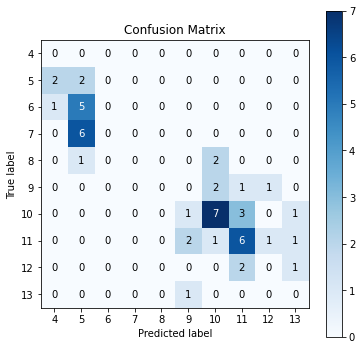

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, predict_eucledian3, figsize=(6,6))

In [ ]:
predict_eucledian6 = KNN_eucledian(X_train, Y_train, X_test, 6)

In [ ]:
metric(Y_test, predict_eucledian6)

accuracy 0.3
precision 0.12261904761904763
recall 0.1628787878787879
F1 0.13272946859903384
MCC 0.19227926343849758
Kappa Cohen 0.18338777414838991
Confusion Matrix
 [[0 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 2 1 1 0]
 [0 0 0 0 0 1 7 3 0 1]
 [0 0 0 0 0 2 1 6 1 1]
 [0 0 0 0 0 0 0 2 0 1]
 [0 0 0 0 0 1 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



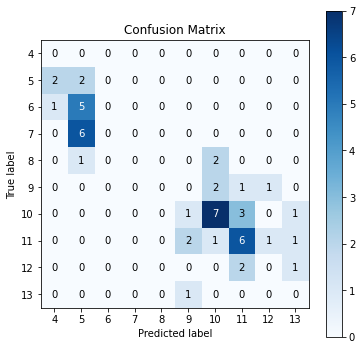

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, predict_eucledian6, figsize=(6,6))

In [ ]:
metric(Y_test, predict_eucledian9)

accuracy 0.3
precision 0.12261904761904763
recall 0.1628787878787879
F1 0.13272946859903384
MCC 0.19227926343849758
Kappa Cohen 0.18338777414838991
Confusion Matrix
 [[0 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 2 1 1 0]
 [0 0 0 0 0 1 7 3 0 1]
 [0 0 0 0 0 2 1 6 1 1]
 [0 0 0 0 0 0 0 2 0 1]
 [0 0 0 0 0 1 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



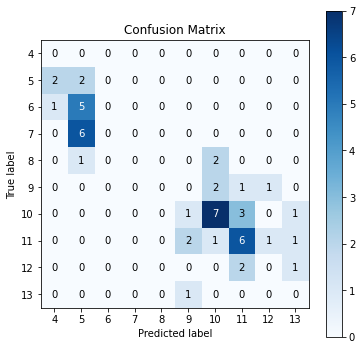

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, predict_eucledian9, figsize=(6,6))

###Чебишев 200/50


In [ ]:
predict_chebushev3 = KNN_chebushev(X_train, Y_train, X_test, 3)
predict_chebushev6 = KNN_chebushev(X_train, Y_train, X_test, 6)
predict_chebushev9 = KNN_chebushev(X_train, Y_train, X_test, 9)

In [ ]:
metric(Y_test, predict_chebushev3)

accuracy 0.1
precision 0.04297520661157025
recall 0.06818181818181818
F1 0.04968944099378882
MCC -0.022857516044124723
Kappa Cohen -0.021798365122615904
Confusion Matrix
 [[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 2 2 0 0 0]
 [0 0 0 0 0 0 2 3 5 2 0]
 [0 0 0 0 0 1 4 4 0 1 1]
 [0 0 0 0 0 0 0 1 2 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



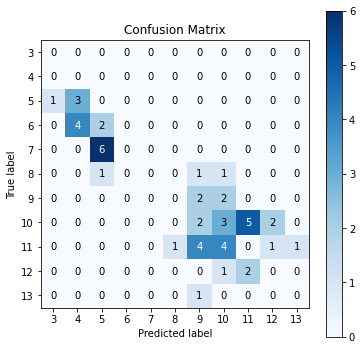

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, predict_chebushev3, figsize=(6,6))

In [ ]:
metric(Y_test, predict_chebushev6)

accuracy 0.1
precision 0.04297520661157025
recall 0.06818181818181818
F1 0.04968944099378882
MCC -0.022857516044124723
Kappa Cohen -0.021798365122615904
Confusion Matrix
 [[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 2 2 0 0 0]
 [0 0 0 0 0 0 2 3 5 2 0]
 [0 0 0 0 0 1 4 4 0 1 1]
 [0 0 0 0 0 0 0 1 2 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



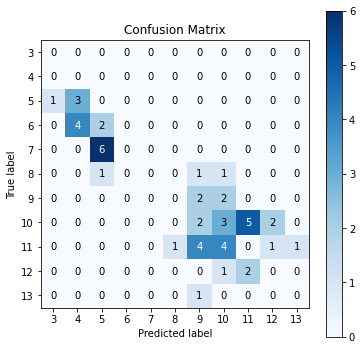

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, predict_chebushev6, figsize=(6,6))

In [ ]:
metric(Y_test, predict_chebushev9)

accuracy 0.1
precision 0.04297520661157025
recall 0.06818181818181818
F1 0.04968944099378882
MCC -0.022857516044124723
Kappa Cohen -0.021798365122615904
Confusion Matrix
 [[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0 0]
 [0 4 2 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 2 2 0 0 0]
 [0 0 0 0 0 0 2 3 5 2 0]
 [0 0 0 0 0 1 4 4 0 1 1]
 [0 0 0 0 0 0 0 1 2 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



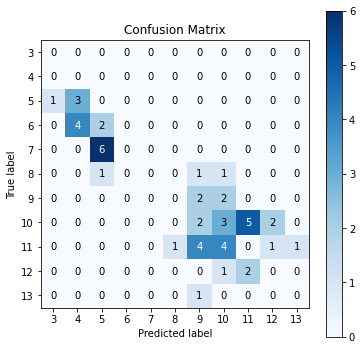

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, predict_chebushev9, figsize=(6,6))

###L1 200/50

In [ ]:
predict_L13 = KNN_L1(X_train, Y_train, X_test, 3)
predict_L16 = KNN_L1(X_train, Y_train, X_test, 6)
predict_L19 = KNN_L1(X_train, Y_train, X_test, 9)

In [ ]:
metric(Y_test, predict_L13)

accuracy 0.12
precision 0.033918128654970764
recall 0.12962962962962962
F1 0.05194805194805195
MCC 0.014104723097214493
Kappa Cohen 0.009009009009009028
Confusion Matrix
 [[ 2  0  2  0  0  0  0  0  0]
 [ 2  4  0  0  0  0  0  0  0]
 [ 5  1  0  0  0  0  0  0  0]
 [ 1  2  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



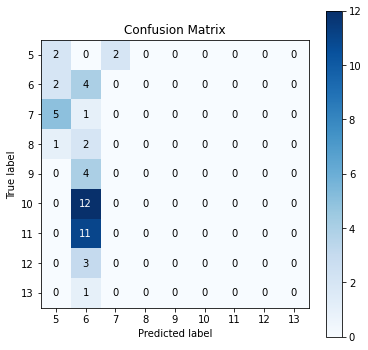

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, predict_L13, figsize=(6,6))

In [ ]:
metric(Y_test, predict_L16)

accuracy 0.12
precision 0.033918128654970764
recall 0.12962962962962962
F1 0.05194805194805195
MCC 0.014104723097214493
Kappa Cohen 0.009009009009009028
Confusion Matrix
 [[ 2  0  2  0  0  0  0  0  0]
 [ 2  4  0  0  0  0  0  0  0]
 [ 5  1  0  0  0  0  0  0  0]
 [ 1  2  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



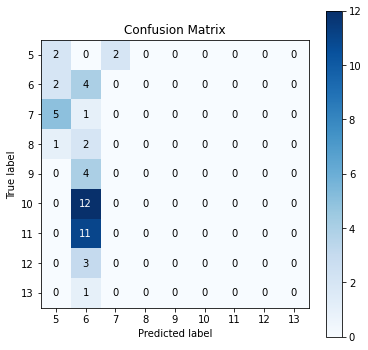

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, predict_L16, figsize=(6,6))

In [ ]:
metric(Y_test, predict_L19)

accuracy 0.12
precision 0.033918128654970764
recall 0.12962962962962962
F1 0.05194805194805195
MCC 0.014104723097214493
Kappa Cohen 0.009009009009009028
Confusion Matrix
 [[ 2  0  2  0  0  0  0  0  0]
 [ 2  4  0  0  0  0  0  0  0]
 [ 5  1  0  0  0  0  0  0  0]
 [ 1  2  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



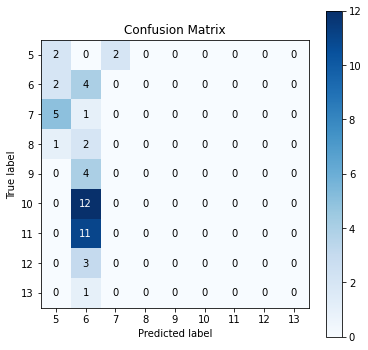

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, predict_L19, figsize=(6,6))

### K-Fold cross validation

In [ ]:
S0=(df2[:50]).reset_index(drop=True)
S1=(df2[50:100]).reset_index(drop=True)
S2=(df2[100:150]).reset_index(drop=True)
S3=(df2[150:200]).reset_index(drop=True)
S4=(df2[200:250]).reset_index(drop=True)
S5=(df2[-50:]).reset_index(drop=True)

set0=pd.concat([S4,S3,S5,S1,S2], ignore_index=True)
set1=pd.concat([S4,S2,S0,S3,S5], ignore_index=True)
set2=pd.concat([S1,S0,S4,S5,S3], ignore_index=True)
set3=pd.concat([S0,S5,S4,S1,S2], ignore_index=True)
set4=pd.concat([S3,S2,S1,S5,S0], ignore_index=True)
set5=pd.concat([S3,S2,S1,S4,S0], ignore_index=True)

In [ ]:
def k_fold(method, KFV_train, KFV_test):
  
    KFV_x_train = KFV_train.iloc[:,:-1].to_numpy()
    KFV_y_train = KFV_train.iloc[:,-1:].to_numpy()

    KFV_x_test = KFV_test.iloc[:,:-1].to_numpy()
    KFV_y_test = KFV_test.iloc[:,-1:].to_numpy()

    KFV_predict = method(KFV_x_train, KFV_y_train, KFV_x_test, 3)

    print('MCC', matthews_corrcoef(KFV_y_test, KFV_predict))

Евклід

In [ ]:
k_fold(KNN_eucledian, set0, S0)
k_fold(KNN_eucledian, set1, S1)
k_fold(KNN_eucledian, set2, S2)
k_fold(KNN_eucledian, set3, S3)
k_fold(KNN_eucledian, set4, S4)
k_fold(KNN_eucledian, set5, S5)

MCC 0.12442075862498438
MCC 0.013220093859400926
MCC 0.037789376660022064
MCC 0.20223356070141285
MCC 0.1174314570837404
MCC 0.21429473285495232


In [ ]:
eucledian_x_train = set0.iloc[:,:-1].to_numpy()
eucledian_y_train = set0.iloc[:,-1:].to_numpy()
eucledian_x_test = S0.iloc[:,:-1].to_numpy()
eucledian_y_test = S0.iloc[:,-1:].to_numpy()
eucledian_predict = KNN_eucledian(eucledian_x_train, eucledian_y_train, eucledian_x_test, 3)

In [ ]:
metric(eucledian_y_test, eucledian_predict)

accuracy 0.28
precision 0.1701388888888889
recall 0.18333333333333335
F1 0.15574009324009325
MCC 0.12442075862498438
Kappa Cohen 0.11764705882352933
Confusion Matrix
 [[1 0 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [4 1 3 1 1 0 0 0]
 [3 7 1 3 4 0 0 0]
 [1 1 1 3 7 1 0 0]
 [0 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



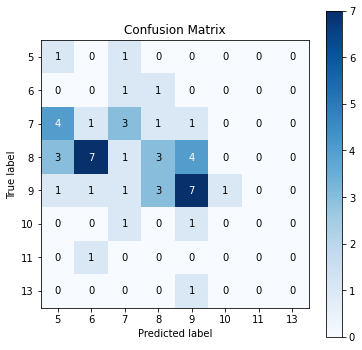

In [ ]:
skplt.metrics.plot_confusion_matrix(eucledian_y_test, eucledian_predict, figsize=(6,6))

Чебишев

In [ ]:
k_fold(KNN_chebushev, set0, S0)
k_fold(KNN_chebushev, set1, S1)
k_fold(KNN_chebushev, set2, S2)
k_fold(KNN_chebushev, set3, S3)
k_fold(KNN_chebushev, set4, S4)
k_fold(KNN_chebushev, set5, S5)

MCC 0.04055818155870759
MCC -0.03172799135835669
MCC 0.08847521070560323
MCC 0.1143020993762243
MCC 0.00542299668209158
MCC 0.0038114118334869112


In [ ]:
chebushev_x_train = set2.iloc[:,:-1].to_numpy()
chebushev_y_train = set2.iloc[:,-1:].to_numpy()
chebushev_x_test = S2.iloc[:,:-1].to_numpy()
chebushev_y_test = S2.iloc[:,-1:].to_numpy()
chebushev_predict = KNN_chebushev(chebushev_x_train, chebushev_y_train, chebushev_x_test, 3)

In [ ]:
metric(chebushev_y_test, chebushev_predict)

accuracy 0.26
precision 0.21666666666666667
recall 0.14351851851851852
F1 0.15070436809567242
MCC 0.08847521070560323
Kappa Cohen 0.07592407592407602
Confusion Matrix
 [[ 0  0  0  0  0  0]
 [ 2  3  2  1  0  0]
 [10  5  9  0  0  0]
 [ 0  6  2  1  0  0]
 [ 6  0  2  0  0  0]
 [ 0  1  0  0  0  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



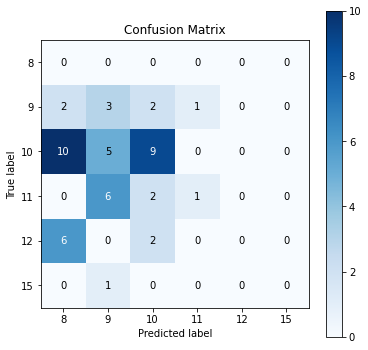

In [ ]:
skplt.metrics.plot_confusion_matrix(chebushev_y_test, chebushev_predict, figsize=(6,6))

L1

In [ ]:
k_fold(KNN_L1, set0, S0)
k_fold(KNN_L1, set1, S1)
k_fold(KNN_L1, set2, S2)
k_fold(KNN_L1, set3, S3)
k_fold(KNN_L1, set4, S4)
k_fold(KNN_L1, set5, S5)

MCC -0.07114807684288156
MCC -0.03414680792221374
MCC 0.08295841969034026
MCC 0.0673640407879381
MCC 0.07326953593978393
MCC 0.06413455676098913


In [ ]:
L1_x_train = set3.iloc[:,:-1].to_numpy()
L1_y_train = set3.iloc[:,-1:].to_numpy()
L1_x_test = S3.iloc[:,:-1].to_numpy()
L1_y_test = S3.iloc[:,-1:].to_numpy()
L1_predict = KNN_L1(L1_x_train, L1_y_train, L1_x_test, 3)

In [ ]:
metric(L1_y_test, L1_predict)

accuracy 0.14
precision 0.061309523809523814
recall 0.125
F1 0.07777777777777778
MCC 0.0673640407879381
Kappa Cohen 0.04782993799822843
Confusion Matrix
 [[0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 3 1 1 0 0 0 0 0 0 0]
 [0 0 1 2 2 0 0 0 0 0 0 0]
 [0 0 2 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 4 1 0 0 0 0 0 0 0]
 [0 0 1 8 0 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



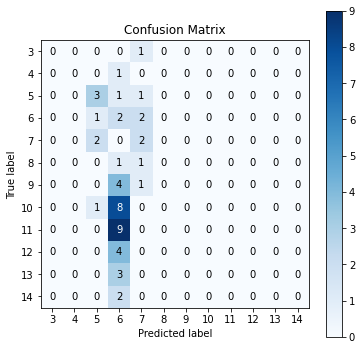

In [ ]:
skplt.metrics.plot_confusion_matrix(L1_y_test, L1_predict, figsize=(6,6))

###**Частина 3. Байєсівський класифікатор.**
1. Розділити файл з даними на навчальну та тестову вибірки.
2. Збудувати наївний байєсівський класифікатор для визначення значення
цільової характеристики (останній стовпчик) на основі вхідних
аргументів (початкові стовпчики).
3. Перевірити якість його роботи, використовуючи файл із даними
тестової вибірки.
4. Для зробленої класифікації:

1) Обчислити метрики accuracy, точності (precision), повноти (recall), $F_1$, MCC (Коефіцієнт кореляції Метьюса), Каппа Коена.

2) Обчислити матрицю помилок (confusion matrix).

3) Надати графічне представлення результатів.

5. Виконати пункти 2-4, використавши алгоритм k-кратної крос валідації (K-Fold cross validation) до наданого датасету.

6. Проаналізуйте отримані результати.


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

In [ ]:
file_url3 = "https://raw.githubusercontent.com/IvanSergeyevichZhuk/ML_KPI/main/Data/Lab2/Part3/MN/MN09-Kovalenko.csv"
data3 = pd.read_csv(file_url3, header=None)
data3

,0,1,2,3,4,5,6,7,8
0,32,State-gov,117927,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black
1,20,Private,137651,Some-college,10,Never-married,Machine-op-inspct,Own-child,Amer-Indian-Eskimo
2,70,Private,131060,7th-8th,4,Married-civ-spouse,Other-service,Husband,White
3,57,Private,346963,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White
4,54,Private,183611,Some-college,10,Married-civ-spouse,Sales,Husband,White
...,...,...,...,...,...,...,...,...,...
295,47,Private,155489,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White
296,18,Private,57413,Some-college,10,Divorced,Other-service,Own-child,White
297,48,Private,320421,HS-grad,9,Married-civ-spouse,Sales,Husband,White
298,50,Self-emp-not-inc,174752,HS-grad,9,Divorced,Farming-fishing,Not-in-family,White


In [ ]:
data3[8].unique()

array([' Black', ' Amer-Indian-Eskimo', ' White', ' Asian-Pac-Islander',
       ' Other'], dtype=object)

In [ ]:
df3 = data3.set_axis([0, 1, 2, 3, 4, 5, 6, 7, 8] , axis=1)
df3 = pd.get_dummies(data=df3, columns=[1, 3, 5, 6, 7])
df3

,0,2,4,8,1_ ?,1_ Federal-gov,1_ Local-gov,1_ Private,1_ Self-emp-inc,1_ Self-emp-not-inc,1_ State-gov,3_ 10th,3_ 11th,3_ 12th,3_ 1st-4th,3_ 5th-6th,3_ 7th-8th,3_ 9th,3_ Assoc-acdm,3_ Assoc-voc,3_ Bachelors,3_ Doctorate,3_ HS-grad,3_ Masters,3_ Prof-school,3_ Some-college,5_ Divorced,5_ Married-civ-spouse,5_ Married-spouse-absent,5_ Never-married,5_ Separated,5_ Widowed,6_ ?,6_ Adm-clerical,6_ Craft-repair,6_ Exec-managerial,6_ Farming-fishing,6_ Handlers-cleaners,6_ Machine-op-inspct,6_ Other-service,6_ Prof-specialty,6_ Protective-serv,6_ Sales,6_ Tech-support,6_ Transport-moving,7_ Husband,7_ Not-in-family,7_ Other-relative,7_ Own-child,7_ Unmarried,7_ Wife
0,32,117927,10,Black,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,20,137651,10,Amer-Indian-Eskimo,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,70,131060,4,White,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,57,346963,13,White,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,54,183611,10,White,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,47,155489,9,White,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
296,18,57413,10,White,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
297,48,320421,9,White,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
298,50,174752,9,White,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
TRAIN = df3.iloc[:250]
TEST = df3.iloc[-50:]

X_train = TRAIN.drop(columns=[8]).reset_index(drop=True).to_numpy()
X_test = TEST.drop(columns=[8]).reset_index(drop=True).to_numpy()

Y_train = TRAIN[8].reset_index(drop=True).to_numpy()
Y_test = TEST[8].reset_index(drop=True).to_numpy()

In [ ]:
class NB():

    def fit(self, X, y):
        self.X, self.y = X, y
        self.classes = np.unique(y)
        self.parameters = []
        for i, c in enumerate(self.classes):
            X_where_c = X[np.where(y == c)]
            self.parameters.append([])

            for col in X_where_c.T:
                parameters = {'mean': col.mean(),'var': col.var()}
                self.parameters[i].append(parameters)

    def classify(self, sample):
        posteriors = []
        for i, c in enumerate(self.classes):
            posterior = np.mean(self.y == c)
            for feature_value, param in zip(sample, self.parameters[i]):
                probability = (1.0 / math.sqrt(2.0 * math.pi * param['var'] + 1e-4)) * (math.exp(-(math.pow(feature_value - param['mean'], 2) / (2 * param['var'] + 1e-4))))
                posterior *= probability
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        y_pred = [self.classify(sample) for sample in X]
        return y_pred

In [ ]:
clf = NB()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)

###Оцінка

In [ ]:
def metric(Y_test, y_pred):
  print('accuracy', accuracy_score(Y_test, y_pred))
  print('precision', precision_score( Y_test, y_pred, average = 'macro'))
  print('recall', recall_score(Y_test, y_pred, average = 'macro'))
  print('F1', f1_score(Y_test, y_pred, average='macro'))
  print('MCC', matthews_corrcoef(Y_test, y_pred))
  print('Kappa Cohen', cohen_kappa_score(Y_test, y_pred))
  print('Confusion Matrix\n', confusion_matrix(Y_test, y_pred))

In [ ]:
metric(Y_test, y_pred)

accuracy 0.36
precision 0.26153846153846155
recall 0.33030303030303027
F1 0.19655172413793104
MCC 0.20235912598690803
Kappa Cohen 0.11406423034330004
Confusion Matrix
 [[ 0  0  0  0  0]
 [ 0  3  0  0  0]
 [ 1  1  1  0  0]
 [ 0  0  0  0  0]
 [ 7  9 12  2 14]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



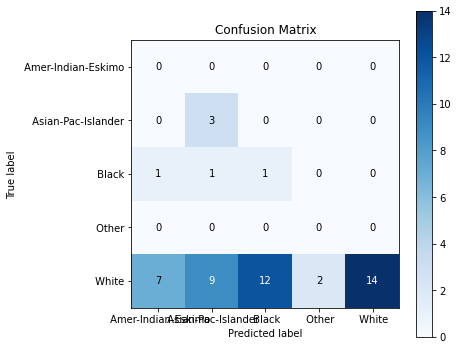

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, y_pred, figsize=(6,6))

###K-Fold cross validation

In [ ]:
S0=(df3[:50]).reset_index(drop=True)
S1=(df3[50:100]).reset_index(drop=True)
S2=(df3[100:150]).reset_index(drop=True)
S3=(df3[150:200]).reset_index(drop=True)
S4=(df3[200:250]).reset_index(drop=True)
S5=(df3[-50:]).reset_index(drop=True)

set0=pd.concat([S4,S3,S5,S1,S2], ignore_index=True)
set1=pd.concat([S4,S2,S0,S3,S5], ignore_index=True)
set2=pd.concat([S1,S0,S4,S5,S3], ignore_index=True)
set3=pd.concat([S0,S5,S4,S1,S2], ignore_index=True)
set4=pd.concat([S3,S2,S1,S5,S0], ignore_index=True)
set5=pd.concat([S3,S2,S1,S4,S0], ignore_index=True)

In [ ]:
def k_fold(KFV_train, KFV_test):
  
    KFV_x_train = KFV_train.drop(columns=[8]).reset_index(drop=True).to_numpy()
    KFV_y_train = KFV_train[8].reset_index(drop=True).to_numpy()

    KFV_x_test = KFV_test.drop(columns=[8]).reset_index(drop=True).to_numpy()
    KFV_y_test = KFV_test[8].reset_index(drop=True).to_numpy()

    clf = NB()
    clf.fit(KFV_x_train, KFV_y_train)
    KFV_predict = clf.predict(KFV_x_test)
    print('accuracy', accuracy_score(KFV_y_test, KFV_predict))

In [ ]:
k_fold(set0, S0)
k_fold(set1, S1)
k_fold(set2, S2)
k_fold(set3, S3)
k_fold(set4, S4)
k_fold(set5, S5)

accuracy 0.3
accuracy 0.34
accuracy 0.24
accuracy 0.3
accuracy 0.24
accuracy 0.36


In [ ]:
NB_x_train = set5.drop(columns=[8]).reset_index(drop=True).to_numpy()
NB_y_train = set5[8].reset_index(drop=True).to_numpy()
NB_x_test = S5.drop(columns=[8]).reset_index(drop=True).to_numpy()
NB_y_test = S5[8].reset_index(drop=True).to_numpy()

clf = NB()
clf.fit(NB_x_train, NB_y_train)
NB_predict = clf.predict(NB_x_test) 

In [ ]:
metric(Y_test, y_pred)

accuracy 0.36
precision 0.26153846153846155
recall 0.33030303030303027
F1 0.19655172413793104
MCC 0.20235912598690803
Kappa Cohen 0.11406423034330004
Confusion Matrix
 [[ 0  0  0  0  0]
 [ 0  3  0  0  0]
 [ 1  1  1  0  0]
 [ 0  0  0  0  0]
 [ 7  9 12  2 14]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



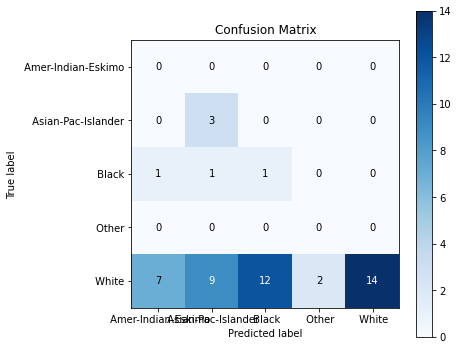

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, y_pred, figsize=(6,6))